# Forecasting prices

## Overview

Train several models to see what's the better performance.

Models:
* Decision Tree Regresion
* KNN
* Bagging
* Boosting

## Import libraries

In [78]:
#import sys
#!{sys.executable} -m pip install seaborn

In [79]:
import datetime as dt
import os
import pandas as pd
import numpy as np
import csv

# Plot
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score

# models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

#Bagging
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

#Neural Network
from sklearn.neural_network import MLPClassifier
from sklearn.grid_search import RandomizedSearchCV

# Add plotly for interactive charts
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.plotly as py
import plotly.graph_objs as go
from plotly import tools



## Initial variables

In [80]:
symbol = "AABA"

## Reading data from CSV file

In [81]:
# Get values from cvs file
filename = "data/" + symbol + ".csv"
headers = ["date", symbol]
portf_value = pd.read_csv(filename, sep=",", names = headers)
portf_value.set_index("date", inplace= True)

In [82]:
# Normalize the prices Dataframe
normed = portf_value.copy()

In [83]:
# Convert price column to float
normed[symbol] = pd.to_numeric(normed[symbol], errors='coerce').fillna(0)

In [84]:
normed.info()
normed.head()

<class 'pandas.core.frame.DataFrame'>
Index: 128 entries, 2018-07-09 to 2019-01-09
Data columns (total 1 columns):
AABA    128 non-null float64
dtypes: float64(1)
memory usage: 2.0+ KB


,AABA
date,
2018-07-09,75.610001
2018-07-10,75.970001
2018-07-11,73.760002
2018-07-12,74.610001
2018-07-13,74.480003


## Getting indicator values

In [85]:
# Momentum
price = normed[symbol]
window = 10
momentum = pd.Series(np.nan, index=price.index)
momentum.iloc[window:] = (price.iloc[window:] / price.values[:-window]) - 1


In [86]:
# Rolling Mean
rolling_mean = price.rolling(window).mean()

In [87]:
# SMA
sma = price / rolling_mean - 1

In [88]:
# RSI
def get_RSI(prices, n=14):
    deltas = np.diff(prices)
    seed = deltas[:n+1]
    up = seed[seed>=0].sum()/n
    down = -seed[seed<0].sum()/n
    rs = up/down
    rsi = np.zeros_like(prices)
    rsi[:n] = 100. - 100./(1.+rs)

    for i in range(n, len(prices)):
        delta = deltas[i-1] # cause the diff is 1 shorter
        if delta>0:
            upval = delta
            downval = 0.
        else:
            upval = 0.
            downval = -delta
        up = (up*(n-1) + upval)/n
        down = (down*(n-1) + downval)/n
        rs = up/down
        rsi[i] = 100. - 100./(1.+rs)
    return rsi

rsi = get_RSI(price)

# Clean nan values
normed = normed.fillna(0)

# Sort dataframe by index
normed.sort_index()



,AABA
date,
2018-07-09,75.610001
2018-07-10,75.970001
2018-07-11,73.760002
2018-07-12,74.610001
2018-07-13,74.480003
2018-07-16,74.660004
2018-07-17,75.360001
2018-07-18,74.660004
2018-07-19,73.360001


## Create dataframe indicators columns

In [89]:
# Create momentum column
normed['Momentum'] = momentum

# Create SMA column
normed['SMA'] = sma

# Create SMA column
normed['RSI'] = rsi


# Sort dataframe by index
normed.sort_index()

# Clean nan values
normed = normed.fillna(0)

normed.head()



,AABA,Momentum,SMA,RSI
date,,,,
2018-07-09,75.610001,0.0,0.0,40.037116
2018-07-10,75.970001,0.0,0.0,40.037116
2018-07-11,73.760002,0.0,0.0,40.037116
2018-07-12,74.610001,0.0,0.0,40.037116
2018-07-13,74.480003,0.0,0.0,40.037116


In [90]:

#missing data
total = normed.isnull().sum().sort_values(ascending=False)
percent = (normed.isnull().sum()/normed.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)
print(missing_data)



          Total  Percent
RSI           0      0.0
SMA           0      0.0
Momentum      0      0.0
AABA          0      0.0


## Correlation matrix

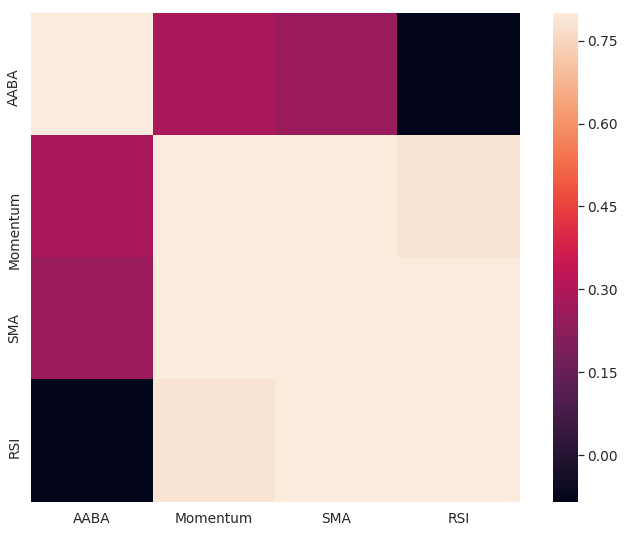

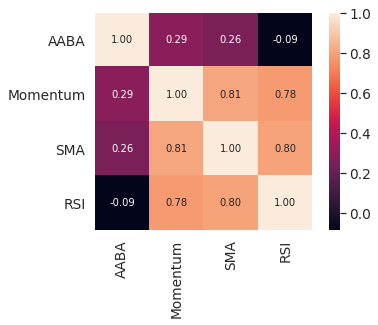

In [91]:
#correlation matrix
corrmat = normed.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);
plt.show()

#treatment correlation matrix
k = 4 #number of variables for heatmap
cols = corrmat.nlargest(k, symbol)[symbol].index
cm = np.corrcoef(normed[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

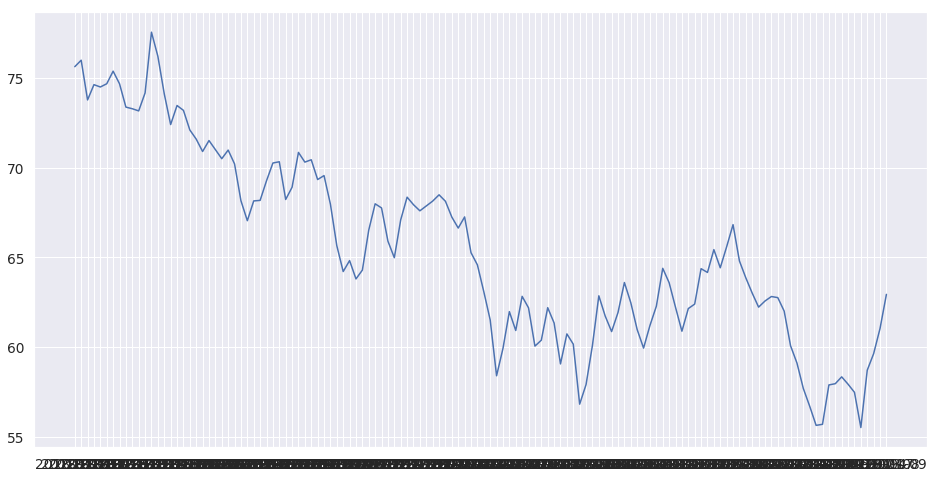

In [105]:

#plot
plt.figure(figsize=(16,8))
plt.plot(normed[symbol], label='Adj. Close Price history')

## Splitting the dataset

In [92]:
# Define X and y
feature_cols = ['Momentum', 'SMA']
X = normed[feature_cols]
y = normed[symbol]
sc_y = StandardScaler()
y = np.array(y).reshape(-1,1)
y = sc_y.fit_transform(y)

print('X matrix dimensionality:', X.shape)
print('Y vector dimensionality:', y.shape)

# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, shuffle=False)


X matrix dimensionality: (128, 2)
Y vector dimensionality: (128, 1)


# Evaluating models

## KNeighbors Regressor

### Hyperparameter optimization

In [131]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

hyper_params = [x for x in range(1,21)]
mse_values = []
for h in hyper_params:
    knn = KNeighborsRegressor(n_neighbors = h, algorithm = 'auto')
    knn.fit(X_train, y_train)
    predictions = knn.predict(X_test)
    mse_values.append(mean_squared_error(y_test, predictions))
    print("Neighbors ", h, "MSE ", mse_values[h-1])


Neighbors  1 MSE  1.0958795073427008
Neighbors  2 MSE  1.1622351822154635
Neighbors  3 MSE  1.233449499975677
Neighbors  4 MSE  1.334783202074334
Neighbors  5 MSE  1.3780686816709407
Neighbors  6 MSE  1.3120314563969135
Neighbors  7 MSE  1.4002505098409448
Neighbors  8 MSE  1.4304891490006373
Neighbors  9 MSE  1.4457991935481869
Neighbors  10 MSE  1.4823580203583449
Neighbors  11 MSE  1.4778116050575991
Neighbors  12 MSE  1.518095590544854
Neighbors  13 MSE  1.4794590560446481
Neighbors  14 MSE  1.4886138173600487
Neighbors  15 MSE  1.4922384351846676
Neighbors  16 MSE  1.5319333426694748
Neighbors  17 MSE  1.5236298763617635
Neighbors  18 MSE  1.5401878523612955
Neighbors  19 MSE  1.5813331411058311
Neighbors  20 MSE  1.5998905714061513


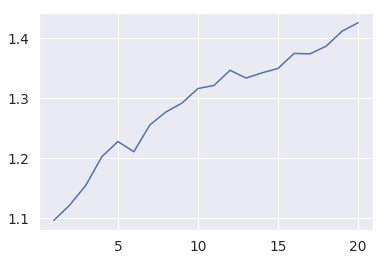

In [128]:
plt.his(hyper_params, mse_values)
plt.show()